Basically a copy-paste of https://www.youtube.com/watch?v=GOBvUA9lK1Q&t. But I'm obviously not perfect, so I may get a little nit-picky if there are things I want to add/delete. I'll try my best to document all I can. 


To start, we're using the Lunar Lander Open AI Gym Environment https://gym.openai.com/envs/LunarLander-v2/.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym 
#from gym import wrappers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
        super(PolicyNetwork,self).__init__()
        self.input_dims = input_dims
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims,self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims,self.n_actions)
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.to(self.device)
        
    def forward(self,observation):
        state = torch.Tensor(observation).to(self.device)
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #no activation, handled later
        
        return x

    
#Now the agent class. We express things in terms of classes and objects, a fundamental building block of 
# OOP and comp sci. 

class Agent(object):
    #contains policy network and more!
    def __init__(self, lr, input_dims, gamma = 0.99, n_actions = 4, l1_size = 256, l2_size = 256):
    
        self.gamma = gamma
        self.reward_memory = [] #way of keeping track of rewards 
        self.action_memory = [] # and actions the agent took
        
        self.policy = PolicyNetwork(lr, input_dims, l1_size, l2_size, n_actions) #probability distribution used by the agent to select actions, given an observation/state. 
    
    def choose_action(self, observation):
        probabilities = F.softmax(self.policy.forward(observation))
        
        #now calculate an actual distribution from this. 
        
        action_probs = torch.distributions.Categorical(probabilities) # probability distribuition dictated by policy network
        
        # now we pick an action using sample method.
        
        action = action_probs.sample()
        
        #keep track of action log probability... log pi!  You know this!
        
        log_probs = action_probs.log_prob(action) #clearly this is a Pytorch specific method of how to select. 
        #looks like it takes distribution, and calculates log probability of that specific action. cool. 
        
        
        #now save. 
        
        self.action_memory.append(log_probs)
        
        #return an action
        
        return action.item() #this item is an integer, now able to get fed into gym env. 
    
    def store_rewards(self,reward):
        self.reward_memory.append(reward) #why not just do this in main? idk, it's a little more convenient. 
        
        
    def learn(self):
        #heart of the problem. 
        self.policy.optimizer.zero_grad()
        
        #It learns at the end of the episode, which is not a good thing! Would want an average of future returns, not per ep. 
        G = np.zeros_like(self.reward_memory,dtype = np.float64) #For mc Reinforce
        for t in range(len(self.reward_memory)):
            G_sum = 0
            discount = 1 
            for k in range(t,len(self.reward_memory)): #why from t? Rewards to go! 
                G_sum += self.reward_memory[k] * discount
                discount *= self.gamma  # decreases for future time steps. 
                
            G[t] = G_sum  # at the end of episode, store sum of returns at timestep t
            
        #standardize to reduce variance. Free lunch! 
        mean = np.mean(G)
        std = np.std(G) if np.std(G) > 0 else 1

        G = (G - mean)/std
        G = torch.Tensor(G).to(self.policy.device) #for some reason, worked like this. Phil had to use a specific data type. 
        loss = 0
        for g, logprob in zip(G, self.action_memory):
            loss += -g * logprob #weight each probbility by future + current reward at that timestpe

                #it's objective is to maximize this prbabil8ty 
            #spoilers. To do this for multiple trajectories, need to iterate over N episodes, and average these losses. 
            
            #another spoiler. Baseline should be subjtracted from here, perhaps just as mean G? 
            
            # another spoiler. Critic also goes here too! 
        #backprop!

        loss.backward()
        self.policy.optimizer.step()

        #zero out and repeat. This is a Sample inefficient MC, and a future improvement 
        self.action_memory = []
        self.reward_memory = []


            #now for the main!
            

In [3]:
#Main 

env = gym.make('LunarLander-v2')
agent = Agent(lr = 0.001, input_dims=[8],gamma=0.99,n_actions=4
             ,l1_size=128,l2_size=128)

score_history = []
score = 0
n_episodes = 2500

#env = wrappers.Monitor(env, 'tmp/lunar-lander',
 #                      video_callable=lambda episodeid: True, force=True)

for i in range(n_episodes):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        env.render()
        action = agent.choose_action(observation)
        observation_,reward, done, info = env.step(action)
        agent.store_rewards(reward)
        observation = observation_ #set the old obvs to the new one
        score += reward
        
    score_history.append(score)
    agent.learn()
    print('episode: ', i, 'score ', score)


/Users/noahkasmanoff/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/noahkasmanoff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


episode:  0 score  -144.9586949310644
episode:  1 score  -271.8127205443703
episode:  2 score  -150.34019583109477
episode:  3 score  -236.44527665051433
episode:  4 score  -135.70245116131235
episode:  5 score  -229.28413205842548
episode:  6 score  -411.3766901649122
episode:  7 score  -260.1035301709883
episode:  8 score  -251.99946036992083
episode:  9 score  -155.6462985607587
episode:  10 score  -158.22565650676142
episode:  11 score  -403.976762394633
episode:  12 score  -162.04154753061934
episode:  13 score  -293.47655596708614
episode:  14 score  -153.94195249684353
episode:  15 score  -269.3367674337127
episode:  16 score  -124.04590077276593
episode:  17 score  -235.42601321899934
episode:  18 score  -165.2374716140478
episode:  19 score  -404.52947895098316
episode:  20 score  -110.28587361456435
episode:  21 score  -120.53795422042411
episode:  22 score  -171.10525550659509
episode:  23 score  -89.20117998954778
episode:  24 score  -149.89164832593983
episode:  25 score  

KeyboardInterrupt: 

Text(0, 0.5, 'Total Rewards')

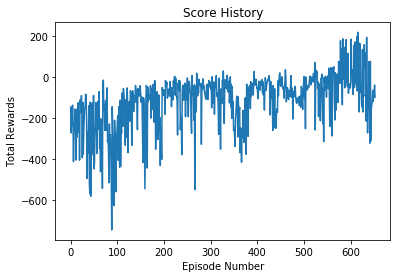

In [6]:
plt.title("Score History")
plt.plot(score_history)
plt.xlabel("Episode Number")
plt.ylabel("Total Rewards")